# Visual search with k-NN

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import tensorflow as tf

In [41]:
with np.load('train_data_np.npz', allow_pickle=False) as npz_file_tr:
    # Load the arrays
    X_tr = npz_file_tr['features']
    y_tr = npz_file_tr['targets']

In [42]:
with np.load('test_data_np.npz', allow_pickle=False) as npz_file_te:
    # Load the arrays
    X_te = npz_file_te['features']
    y_te = npz_file_te['targets']

In [43]:
with np.load('val_data_np.npz', allow_pickle=False) as npz_file_val:
    # Load the arrays
    X_val = npz_file_val['features']
    y_val = npz_file_val['targets']

In [44]:
# Folder list
folder_list = ["bike", "car", "motorcycle", "other", "truck", "van"]

## Fit and tune a k-NN classifier. Visualize the train and validation curves

#### FIt the k-NN classifier

In [45]:
y_val.shape

(139,)

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [47]:
X_tr = X_tr.reshape(280, 1280)
X_te = X_te.reshape(52, 1280)
X_val = X_val.reshape(139,1280)

In [48]:
# Create a k-NN pipeline with K=5
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5))]
)

# Fit estimator
knn_pipe.fit(X_tr, y_tr)

# Evaluate on validation set
accuracy = knn_pipe.score(X_val, y_val)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.892


*Comments:* The accuracy of the model is alreay quite good at 89%. 

#### Tuning the model based on K values 
We are tuning the model on k values to visualize the train and validation curves

In [49]:
#Tuning the model based on K values 

# Generate a set of k values
k_values = np.r_[1, np.arange(5, 20, step=2)]
k_values

array([ 1,  5,  7,  9, 11, 13, 15, 17, 19])

In [50]:
# Variable to store the results
gs_results = []

# Grid search
for k in k_values:
    # Fit k-NN model
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_tr, y_tr)

    # Save model and its performance on training/validation sets
    gs_results.append(
        {
            "k": k,
            "train_accuracy": knn_pipe.score(X_tr, y_tr),
            "valid_accuracy": knn_pipe.score(X_val, y_val),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by="valid_accuracy", ascending=False).head()

,k,train_accuracy,valid_accuracy
1,5,0.917857,0.892086
2,7,0.900000,0.884892
3,9,0.885714,0.870504
4,11,0.885714,0.870504
0,1,1.000000,0.863309


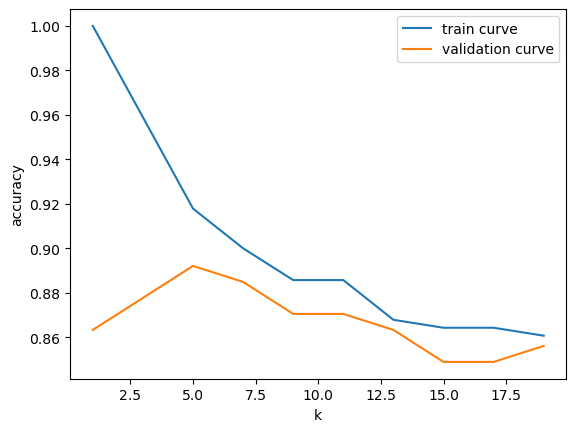

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results["k"], gs_results["train_accuracy"], label="train curve")
plt.plot(gs_results["k"], gs_results["valid_accuracy"], label="validation curve")
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()

In [52]:
# Get entry with the best validation MSE
best_result = gs_results.loc[gs_results.valid_accuracy.idxmax()]

# Print the details
print("Best K: {}".format(best_result.k))
print("Validation Accuracy: {:.4f}".format(best_result.valid_accuracy))

Best K: 5.0
Validation Accuracy: 0.8921


*Comments:* As expected, the more we increase the K hyperparameter, the less the model accurate. We can highlight that validation curve is above the trainning curve which is unusual. In this case, a model with an hyperparameter K=5 shows the highest accuracy at 89%

### Provide a classification report and visualize the confusion matrix of the test dataset

In [53]:
X_final = np.concatenate((X_tr, X_val.reshape(139, 1280)), axis=0) 
y_final = np.concatenate((y_tr, y_val), axis=0) 
X_final.shape, y_final.shape

((419, 1280), (419,))

In [54]:
# setup the best k=5 parameter
knn_pipe_final = knn_pipe.set_params(knn__n_neighbors=5)
knn_pipe_final.fit(X_final, y_final)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [55]:
from sklearn.metrics import classification_report


# Classification report
y_te_pred = knn_pipe_final.predict(X_te)
print(classification_report(y_true=y_te, y_pred=y_te_pred))

              precision    recall  f1-score   support

        bike       1.00      1.00      1.00        12
         car       0.92      1.00      0.96        11
  motorcycle       1.00      1.00      1.00         9
       other       1.00      0.88      0.93         8
       truck       0.88      1.00      0.93         7
         van       1.00      0.80      0.89         5

    accuracy                           0.96        52
   macro avg       0.97      0.95      0.95        52
weighted avg       0.97      0.96      0.96        52



In [56]:
# Calculate and store the score on test set
knn_score = knn_pipe_final.score(X_te, y_te) * 100
knn_score

96.15384615384616

*Comments:* 
- Firstly the classification reports hows that the KNN model has a 100% accuracy and recall to identify bikes and motorbikes, which means that we can strongly rely on this model for this category. 
- Then the accuracy and recals decreases for cars, but the recall is 100% which means that the doesn't miss True positives.
- Interestingly the model has a 100% accuracy for other category meaning that the model is highly selective and predicts the positive class when it is certain, however, the recall rate is 0,88 meaning that the model is missing a few True positive. Consequently the f1 score is 93%.
- The situation is opposite for trucks where True positive are very well detected, and the accuracy is 88%
*Overall, this model is reliable with aweighted average f1 score at 96%.*

### Pick an image which was correctly classified in the test set and plot its 10 nearest neighbors from the training set. 
As a first step, we will select an image into the bike test set as the model recognizes bikes perfectly. Then, we will transform this image to be converted into high level features before standardizing it. afterwards, we are using the kneighbors function to identify the 10 nearest images

In [57]:
y_raw = y_te

In [58]:
# Identify indices which are incorrectly and well classified
misclassified_indices = np.where(y_raw != y_te_pred)[0]
correctly_classified_indices = np.where(y_raw == y_te_pred)[0]

# Create a DataFrame which gather well classified and mi
misclassified_data = pd.DataFrame({
    'Index misclassified': misclassified_indices,
    'True Label misclassified group': y_raw[misclassified_indices],
    'Predicted Label_misclassified group': y_te_pred[misclassified_indices], 
})
    
correctly_classified_data = pd.DataFrame({
    'Index well classified': correctly_classified_indices,
    'True Label well classified group': y_raw[correctly_classified_indices],
    'Predicted Label well classified group': y_te_pred[correctly_classified_indices]
})

In [59]:
#Get the correctly
correctly_classified_data

,Index well classified,True Label well classified group,Predicted Label well classified group
0,0,bike,bike
1,1,bike,bike
2,2,bike,bike
3,3,bike,bike
4,4,bike,bike
5,5,bike,bike
6,6,bike,bike
7,7,bike,bike
8,8,bike,bike
9,9,bike,bike


In [60]:
# Visualize misclassified data
misclassified_data

,Index misclassified,True Label misclassified group,Predicted Label_misclassified group
0,33,other,truck
1,48,van,car


*Comments:*  We decide to select the image indice 28 which is correctly predicted by the model. Then we use the scikit learn neighbors model to find its closest images. To do so, we use our model previously fitted to plot an image (indice 28: motorbike) and its neighbors.

In [61]:
# Function to extract all images from a folder and store it in a variable image without transformation
def load_images(folder_path):
    images = []  # List to store loaded images
    
    # Walk through the folder and its subfolders
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            # Full path to the current file
            file_path = os.path.join(root, file_name)

            # Open the image file and convert into np.array
            img = np.array(Image.open(file_path))
                    # Append a copy of the image to the list
            images.append(img)
    return images

In [62]:
# Folder locations
import os
notebook_directory = os.getcwd()
train_path = os.path.join(notebook_directory, "train")
val_path = os.path.join(notebook_directory, "valid")
test_path = os.path.join(notebook_directory, "test")

# Load images from the train and test sets
train_images = load_images(train_path)  
test_images = load_images(test_path)

In [63]:
#well classified_image features
test_indice= 28
image_28 = X_te[28].reshape(1,-1)

In [64]:
# DelectPredict the label based on data with the trained KNN model
knn_pipe_final.predict(image_28)

array(['motorcycle'], dtype='<U10')

In [65]:
# Build the knn model with the "best" n parameter
knn_1 = KNeighborsClassifier(n_neighbors=5)

# Fitting the model on the whole dataset
knn_1.fit(X_tr, y_tr)

KNeighborsClassifier()

In [66]:
# Identifying the 10 nearest images
distances, indices = knn_1.kneighbors(X=image_28, n_neighbors=10)

In [67]:
nearest_indices = indices[0]
distances = distances[0]
distances = distances.astype("float").round(2)
distances

array([17.13, 17.21, 17.49, 17.52, 17.95, 18.07, 18.16, 18.21, 18.55,
       18.61])

These figures means that the 6th picture is at a distance of 41,7 fron the closest data point which has a rank of 49 in the dataset. 

In [68]:
nearest_indices

array([158, 141, 135, 134, 143, 142, 177, 155,  11, 157], dtype=int64)

In [69]:
# Select the nearest images using nearest_indices
nearest_images = [train_images[i] for i in nearest_indices]

# Select the test image corresponding to test_indice
test_img_data = [test_images[test_indice]]
# Stack the test image and nearest images along a new axis
all_data_class = np.stack(test_img_data + nearest_images, axis=0)

all_distances = np.append("test", distances) 

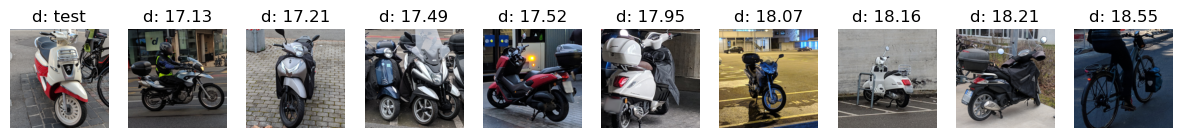

In [70]:
fig, axes = plt.subplots(1, len(nearest_images), figsize=(15, 10))
for ax, img, dist in zip(axes, all_data_class, all_distances):
    ax.imshow(img)
    ax.set_title(f"d: {dist}")
    ax.axis('off') 


*Comments:* The test image indice 28 is a motorcycle and 9 images among the 10 neighbors from the train set are motorcycles as well. We can highlight that 2 of these motorbikes are white with the same shape than the test image. the image with a distance of 18.55 is a bike, but the image is very dark and the bike is geared with bags which can be confusing for the model

### Pick an image which was misclassified in the test set and plot its 10 neighbors from the training set

In [71]:
# We select the misclassified image number 48
test_indice_misc = 48
#miclassified_image features
image_48 = X_te[48].reshape(1,-1)

In [72]:
# DelectPredict the label based on data with the trained KNN model
knn_pipe.predict(image_48)

array(['car'], dtype='<U10')

In [73]:
# Identifying the 10 nearest images
distances, indices = knn_1.kneighbors(X=image_48, n_neighbors=10)

In [74]:
nearest_indices_misc = indices[0]
distances_misc = distances[0]
distances_misc = distances_misc.astype("float").round(2)
distances_misc

array([15.04, 15.6 , 15.87, 16.46, 16.48, 16.55, 16.73, 16.96, 17.1 ,
       17.19])

In [75]:
# Select the nearest images using nearest_indices
nearest_images_misc = [train_images[i] for i in nearest_indices_misc]

# Select the test image corresponding to test_indice
test_img_data_misc = [test_images[test_indice_misc]]
# Stack the test image and nearest images along a new axis
all_data_class_misc = np.stack(test_img_data_misc + nearest_images_misc, axis=0)

all_distances_misc = np.append("test", distances_misc) 

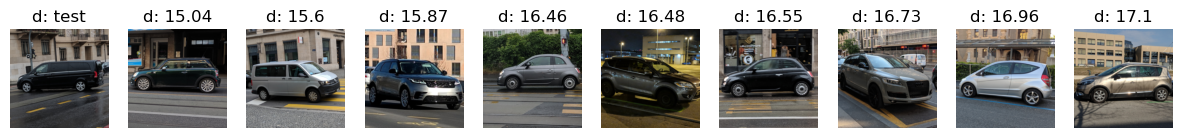

In [76]:
fig, axes = plt.subplots(1, len(nearest_images_misc), figsize=(15, 10))
for ax, img, dist in zip(axes, all_data_class_misc, all_distances_misc):
    ax.imshow(img)
    ax.set_title(f"d: {dist}")
    ax.axis('off')


*Comments:* We can see that this misclassified image has neighbors which are mainly cars. But these cars have a shape of mivivans and this is probably the shape of these cars which lead the model to conclude that the test image was a van.
We are now saving the score into a SQL table 

In [77]:
# Saving the knn score into a SQL Table results_table 
import sqlite3

knn_data = {'model': ['k-NN'],
        'test_accuracy': [knn_score]}
knn_df = pd.DataFrame(knn_data)

# Save to SQLite
conn = sqlite3.connect('results.db')
knn_df.to_sql('results_table', conn, if_exists="append", index=False)
conn.close()